In [ ]:
%pip install qiskit==1.2.4
%pip install qiskit-aer==0.15.1
%pip install pylatexenc==2.10

steps:

alice and bob want to establish a shared key made of N bits.

## requirements
start with a sequence of entangled pairs of qbits
- could've been sent by a 3rd party
- each pair is in state 1/sq2(|01> - |10>)

## testing entanglement (see lecture 8 & lab 4B)
to test the entanglement, (for each pair)
1. alice chooses randomly Z or X.
2. bob chooses randomly W = 1/sq2(X+Z) or V = 1/sq2(X-Z)
3. Alice and Bob measure $S = |\langle X \otimes W \rangle - \langle X \otimes V \rangle + \langle Z \otimes W \rangle + \langle Z \otimes V \rangle|$
- $\langle X \otimes W \rangle$ is the avg value of the result of measuring.
- measuring means:
    1. measuring Alice's qbit in the basis corresponding to X **and**
    2. measuring Bob's in the basis corresponding to W

what is the basis coresponding to X or W?

4. the result is converted {0, 1} $\rightarrow$ {+1, -1}
5. these values are multiplied together

after doing this **for each pair**,
the average values from that are added and then divided by the length of the sequence.



bob and alice never measure in the same basis as each other,
so they're never guaranteed to get the same result from both of their measurements.


IF THE BASIS IS THE SAME.. THE RESULT IS GUARANTEED THE SAME

In [90]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_gate
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
from qiskit import transpile 
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit import ControlledGate
import math 

# The aim of the assignment is to simulate the Ekert91 key distribution protocol.

# This notebook is for a simulation of the protocol without an attacker.

def show_latex(circuit, bits):
    state = Statevector.from_int(0, 2**bits)
    state = state.evolve(circuit)
    display(state.draw("latex"))

def randomProb(render=False, ZeroStat=1/2, phi=math.pi/2):
    # note: this is is radians.
    theta = 2 * math.acos(math.sqrt(ZeroStat) )    
    
    circuit = QuantumCircuit(1)
    circuit.r(theta, phi, 0)
    
    # small interrupt to render latex for our state
    if (render):
        state = Statevector.from_int(0, 2**1)
        state = state.evolve(circuit)
        display(state.draw("latex"))
    
    circuit.measure_all()
    
    backend = BasicSimulator()
    compiled = transpile(circuit, backend)
    job_sim = backend.run(compiled, shots=1)
    results_sim = job_sim.result()
    counts = results_sim.get_counts()
    return int(list(counts.keys())[0])

def random50(render=False):
    return randomProb(render, 1/2, math.pi/2)

def random33(render=False):
    """
    -ie^-io sin(theta/2) = 2/sq(3)
    theta = 1.91
    i*-ie^-io  = i *  2/sq(3) / sin(1.91/2)
    -io = ln(i *  2/sq(3) / sin(1.91/2))
    o = ln(i *  2/sq(3) / sin(1.91/2)) / -i
    """
    # math.log(i * 2/math.sqrt(3) / math.sin(theta/2), math.e)
    # TODO ^ COME BACK TO THIS
    
    return randomProb(render, 1/3, phi=math.pi/2)


random50(True)
random33(True)
# result = [random33() for i in range(1)]
# print(result)
# print(sum(result)/len(result))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

1

<IPython.core.display.Latex object>

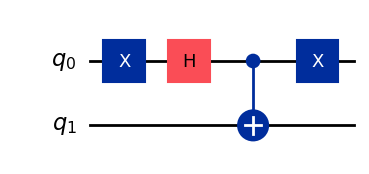

In [111]:
finalKey = []
S = {[1, 1]:0, [1,3]:0, [3,1]:0, [3,3]:0}

for qbitI in range(4):
    # first, create the entangled pair
    # circuit_to_gate

    # build the bell state
    circuit = QuantumCircuit(2)
    circuit.x(0)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.x(0)

    show_latex(circuit, 2)
    display(circuit.draw("mpl"))
    
    
    # Alice chooses an operator Ai randomly from her set of three
    if random30() == 1:
        i = 0
        circuit.x(0)
    else if random30() == 1:
        i = 1
        circuit.w(0)
    else:
        i = 2
        circuit.z(0)

    # Bob chooses an operator Bi randomly from his set of three
    if random30() == 1:
        j = 0
        circuit.x(1)
    else if random30() == 1:
        j = 1
        circuit.w(1)
    else:
        j = 2
        circuit.z(1)


    circuit.measure_all()
    backend = BasicSimulator()
    compiled = transpile(circuit, backend)
    job_sim = backend.run(compiled, shots=1)
    results_sim = job_sim.result()
    counts = results_sim.get_counts()
    measurements = list(counts.keys())

    # operator choices are shared now.

    if (i == 2 and j == 1) or (i == 3 and j == 2):
        finalKey.append(measurements)
    else:
        measurements = [val * -2 + 1 for val in measurements]
        S[i, j] += measurements[0] * measurements[1]
            
    break

Ssum = math.abs(S[[1, 1]] - s[[1, 3]] + S[[3, 1]] + S[[3, 3]])